In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm

assert torch.cuda.is_available()

In [2]:
class MyConv2d(nn.Module):
    """
    Receives a (n, c_in, h, w) tensor, returns a (n, c_out, h, w) tensor.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, 
                 init='xavier'):
        super().__init__()
        self.__dict__.update(locals())
        assert in_channels%groups == 0, "Groups must divide in_channels evenly."
        self.weight = torch.zeros((out_channels, in_channels//groups, kernel_size, kernel_size))
        self.init_weight(init)
        self.bias = nn.Parameter(torch.zeros(out_channels))
        
    def init_weight(self, init='xavier'):
        variance = 2/(self.kernel_size**2 * self.in_channels)
        if init == 'xavier':
            self.weight = nn.Parameter(torch.normal(mean=torch.zeros_like(self.weight), std=np.sqrt(variance)))
        elif init == 'uniform':
            width = variance
            self.weight = nn.Parameter(2*width*torch.rand_like(self.weight) - width)
        elif init == 'orthogonal':
            # init with Xavier
            c_out, c_in, k, _ = self.weight.shape
            if c_in*k*k < c_out:
                # can't do orthogonal since we have a wide matrix
                self.init_weight(init='xavier')
                return
            X = np.random.random((c_out, c_in*k*k))
            U, _, Vt = np.linalg.svd(X, full_matrices=False)
            W = Vt.reshape(c_out, c_in, k, k)
            self.weight = nn.Parameter(torch.tensor(W).float())
        else:
            assert False, "Invalid 'init' parameter"
            
        
    def forward(self, input):
        return F.conv2d(input=input, weight=self.weight, bias=self.bias, stride=self.stride, padding=self.padding,
                       dilation=self.dilation, groups=self.groups)
    
class MyCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean'):
        super().__init__()
        self.__dict__.update(locals())
        
    def forward(self, input, target):
        n, c = input.shape
        logsumexp = input.exp().sum(dim=1).log().cuda()
        negative_class_prob = torch.zeros(n).cuda()
        for i in range(n):
            negative_class_prob[i] = -input[i,target[i]]
        return torch.mean(negative_class_prob + logsumexp)

class MyDeepModel(nn.Module):
  # We'll include nn.Linear as a good, easy starting point
  
    def __init__(self, init='xavier'):
        """
        A fully-connected linear layer that takes m inputs and returns n outputs.
        """
        super().__init__()
        self.conv = nn.Sequential(
            MyConv2d(1, 32, kernel_size=3, init=init), # (32, 26, 26)
            nn.ReLU(),

            MyConv2d(32, 32, kernel_size=3, init=init), # (64, 24, 24)
            nn.MaxPool2d(2), # (64, 12, 12)
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(32*12*12, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.conv(x)
        n, c, h, w = x.size()
        x = x.view(n, c*h*w)
        x = self.fc(x)
        return x

    def param_count(self):
        return np.sum([np.prod(param.shape) for param in list(self.parameters())])
  

class FashionDataset(Dataset):
    # Includes the FashionMNIST dataset.

    def __init__(self, train=True):
        super().__init__()
        transform = transforms.Compose([transforms.ToTensor()])
        self.train = train
        self.dataset = datasets.FashionMNIST(root="", 
                                             train=train, 
                                             download=True,
                                             transform=transform, 
                                             target_transform=None)

    def __getitem__(self, key):
        images, labels = self.dataset[key]
        return images, torch.eye(10)[labels]

    def __len__(self):
        if self.train:
            return len(self.dataset)
        else:
            return 256*4 # len(self.dataset) 
        
print(format(MyDeepModel().param_count(), ','), "parameters")

600,810 parameters


In [4]:
train_dataset = FashionDataset(train=True)
test_dataset = FashionDataset(train=False)
model = MyDeepModel(init='xavier')
model = model.cuda() # moves the model to the GPU
objective = MyCrossEntropyLoss() # includes the softmax in itself, so don't double up in the net.
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.005)
train_loader = DataLoader(dataset=train_dataset, 
                    batch_size=256, 
                    pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=256,
                         pin_memory=True)

training_losses = []
validation_losses = []
training_accuracy = []
validation_accuracy = []

num_epochs = 20

loop = tqdm(total=num_epochs*len(train_loader), position=0)

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        x, y_truth = data
        x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

        optimizer.zero_grad()

        y_hat = model(x)
        loss = objective(y_hat, y_truth.argmax(dim=1))
        acc = torch.mean((y_hat.argmax(dim=1) == y_truth.argmax(dim=1)).float())

        training_losses.append(loss)

        loop.set_description("loss: {:.3f}, acc: {:.3f}".format(loss.item(), acc.item()))
        loop.update(1)

        loss.backward()

        optimizer.step()
        
        if i%(235*4) == 0:
            training_accuracy.append(acc)
            validation_accuracy.append(np.mean([
                torch.mean((model(x.cuda()).argmax(dim=1) == y_truth.cuda().argmax(dim=1)).float()).item()
                for x, y_truth in test_loader
            ]))
        
        
loop.close()

loss: 0.296, acc: 0.906: 100%|██████████| 4700/4700 [05:41<00:00, 13.74it/s]


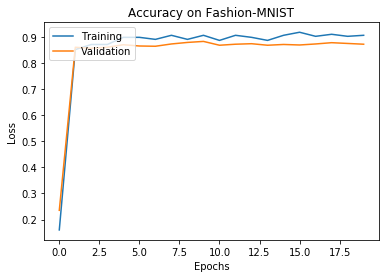

Training Accuracy: 0.90625
Validation Accuracy: 0.8720703125


In [5]:
def display_error(training_loss, validation_loss, training_timesteps=235, validation_timesteps=235):
    """
    Parameters:
    training_error ((N,) ndarray): the training error per iteration.
    validation_error ((N,) ndarray): the validation error per iteration.
    """
    xs = np.arange(len(training_loss))
#     xs = training_timesteps*np.arange(len(training_loss))
    plt.plot(xs, training_loss, label="Training")
#     xs = validation_timesteps*np.arange(len(validation_loss))
    plt.plot(xs, validation_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Accuracy on Fashion-MNIST")
    plt.legend(loc='upper left')
    plt.show()
  
display_error(training_accuracy, validation_accuracy)
print("Training Accuracy:", training_accuracy[-1].item())
print("Validation Accuracy:", validation_accuracy[-1])

# Quiz Questions

Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3, 3), padding=(1, 1))

(c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size=(3, 3), padding=(2, 2))

(c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size=(3, 3), padding=(6, 6))

Using a Kernel size of 5×5:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 5), padding=(2, 2))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 5), padding=(3, 3))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 5), padding=(9, 9))

Using Kernel size of 5×3:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 3), padding=(1, 0))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 3), padding=(2, 1))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 3), padding=(3, 2))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 3), padding=(9, 8))

Determine the kernel that requires the smallest padding size to make the following mappings possible:

(c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : Not possible to get an odd output with an odd kernel with symmetric padding.

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(1, 1), padding=(0, 0))